# Groningen aardbeving analyse

In [ ]:
# dataset 1 KNMI: https://dataplatform.knmi.nl/dataset/aardbevingen-cijfers-1
# api 1 'Earthquakes - facts and figures for the Groningen gas field'
# https://api.dataplatform.knmi.nl/open-data/v1/datasets/aardbevingen_cijfers/versions/1/files

# dataset 2 KNMI: https://dataplatform.knmi.nl/dataset/aardbevingen-nederland-2
# api 2 'Earthquakes - last 100 earthquakes in the Netherlands and near surrounding'
# https://api.dataplatform.knmi.nl/open-data/v1/datasets/aardbevingen_nederland/versions/2/files

# background info
# https://developer.dataplatform.knmi.nl/example-scripts

# temp key
# eyJvcmciOiI1ZTU1NGUxOTI3NGE5NjAwMDEyYTNlYjEiLCJpZCI6IjYzNmIyMjNiNjEzYjQ3OTQ4MDk1NGUxYTRkN2I5ZGYxIiwiaCI6Im11cm11cjEyOCJ9

In [96]:
# import libraries
import logging
import sys
from datetime import datetime
from pathlib import Path
import requests
import json
import pandas as pd   
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore' )

In [97]:
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel("INFO")

api_url = "https://api.dataplatform.knmi.nl/open-data"
api_version = "v1"

def download_file(datasetname, datasetversion, filenumber):
    # Parameters
    api_key = "eyJvcmciOiI1ZTU1NGUxOTI3NGE5NjAwMDEyYTNlYjEiLCJpZCI6IjYzNmIyMjNiNjEzYjQ3OTQ4MDk1NGUxYTRkN2I5ZGYxIiwiaCI6Im11cm11cjEyOCJ9"
    dataset_name = datasetname
    dataset_version = datasetversion
    max_keys = "10"

    # Use list files request to request first 10 files of the day.
    timestamp = datetime.utcnow().date().strftime("%Y%m%d")
    start_after_filename_prefix = f"KMDS__OPER_P___10M_OBS_L2_{timestamp}"
    list_files_response = requests.get(
        f"{api_url}/{api_version}/datasets/{dataset_name}/versions/{dataset_version}/files",
        headers={"Authorization": api_key},
        params={"maxKeys": max_keys, "startAfterFilename": start_after_filename_prefix},
    )
    list_files = list_files_response.json()

    logger.info(f"List files response:\n{list_files}")
    dataset_files = list_files.get("files")

    # Retrieve first file in the list files response
    filename = dataset_files[filenumber].get("filename")
    logger.info(f"Retrieve file with name: {filename}")
    endpoint = f"{api_url}/{api_version}/datasets/{dataset_name}/versions/{dataset_version}/files/{filename}/url"
    get_file_response = requests.get(endpoint, headers={"Authorization": api_key})
    if get_file_response.status_code != 200:
        logger.error("Unable to retrieve download url for file")
        logger.error(get_file_response.text)
        sys.exit(1)

    download_url = get_file_response.json().get("temporaryDownloadUrl")
    dataset_file_response = requests.get(download_url)
    if dataset_file_response.status_code != 200:
        logger.error("Unable to download file using download URL")
        logger.error(dataset_file_response.text)
        sys.exit(1)

    # Write dataset file to disk
    p = Path("aantal_aardbevingen_" + str(filenumber) + ".json")
    p.write_bytes(dataset_file_response.content)
    logger.info(f"Successfully downloaded dataset file to {p}")



In [98]:
download_file("aardbevingen_cijfers", 1, 1)

INFO:__main__:List files response:
{'isTruncated': True, 'resultCount': 10, 'files': [{'filename': 'aantal-aardbevingen-20200625144101.json', 'size': 5787, 'lastModified': '2020-06-25T15:23:29+00:00'}, {'filename': 'aantal-aardbevingen-20200625150100.json', 'size': 5787, 'lastModified': '2020-06-25T15:23:30+00:00'}, {'filename': 'aantal-aardbevingen-20200626000824.json', 'size': 5787, 'lastModified': '2020-06-26T00:08:31+00:00'}, {'filename': 'aantal-aardbevingen-20200627000828.json', 'size': 5787, 'lastModified': '2020-06-27T00:09:30+00:00'}, {'filename': 'aantal-aardbevingen-20200628000829.json', 'size': 5787, 'lastModified': '2020-06-28T00:09:30+00:00'}, {'filename': 'aantal-aardbevingen-20200629000828.json', 'size': 5787, 'lastModified': '2020-06-29T00:09:30+00:00'}, {'filename': 'aantal-aardbevingen-20200630061724.json', 'size': 5787, 'lastModified': '2020-06-30T06:17:30+00:00'}, {'filename': 'aantal-aardbevingen-20200630152024.json', 'size': 5787, 'lastModified': '2020-06-30T15:2

In [44]:
download_file("aardbevingen_nederland", 2, 0)

INFO:__main__:List files response:
{'isTruncated': False, 'resultCount': 1, 'files': [{'filename': 'SEISM_OPER_P___EQ100___L2.nc', 'size': 78640, 'lastModified': '2022-08-28T07:35:44+00:00'}], 'maxResults': 10, 'startAfterFilename': 'KMDS__OPER_P___10M_OBS_L2_20220907'}
INFO:__main__:Retrieve file with name: SEISM_OPER_P___EQ100___L2.nc
INFO:__main__:Successfully downloaded dataset file to SEISM_OPER_P___EQ100___L2.nc


In [361]:
with open('aantal_aardbevingen_0.json','r') as f: data = json.loads(f.read())
df = data['data']
df = pd.json_normalize(df['1991'])
store = df.assign(year=[1991])
store

,1.0,1.5,2.0,2.5,3.0,3.5,max,year
0,0,0,0,1,0,0,0,1991


In [362]:
count = 1992
while(count <2021):
    df = pd.json_normalize(data1[str(count)])
    df =  df.assign(year=[count])
    store = store.append(df)
    count += 1

store.columns = ['one', 'onefive', 'two', 'twofive', 'three', 'threefive', 'max', 'year']
store['Total'] = store['one'] + store['onefive'] + store['onefive'] + store['two'] + store['twofive'] + store['three'] + store['threefive'] + store['max']

store

,one,onefive,two,twofive,three,threefive,max,year,Total
0,0,0,0,1,0,0,0,1991,1
0,0,2,0,0,0,0,0,1992,4
0,4,7,2,2,0,0,0,1993,22
0,3,13,4,1,2,0,0,1994,36
0,1,6,3,1,0,0,0,1995,17
0,6,3,1,1,0,0,0,1996,14
0,6,9,6,0,0,0,0,1997,30
0,4,5,3,2,1,0,0,1998,20
0,4,6,4,1,0,0,0,1999,21
0,1,5,4,1,2,0,0,2000,18


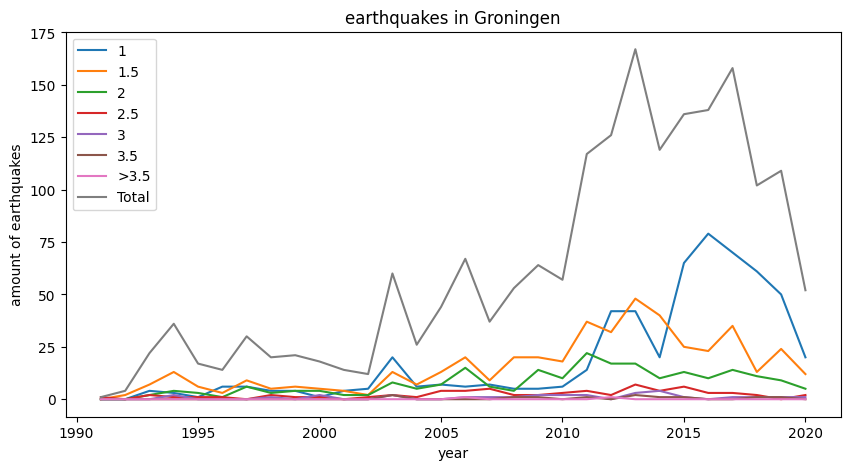

In [324]:
#plotting of data
plt.figure(figsize=(10,5))

x = store['year']
plt.plot(x, store['one'], label = '1')
plt.plot(x, store['onefive'], label = '1.5')
plt.plot(x, store['two'], label = '2')
plt.plot(x, store['twofive'], label = '2.5')
plt.plot(x, store['three'], label = '3')
plt.plot(x, store['threefive'], label = '3.5')
plt.plot(x, store['max'], label = '>3.5')
plt.plot(x, store['Total'], label = 'Total')

plt.xlabel('year')
plt.ylabel('amount of earthquakes')
plt.title('earthquakes in Groningen')
plt.legend()
plt.show()

In [325]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [403]:
df = store[['Total', 'year']]


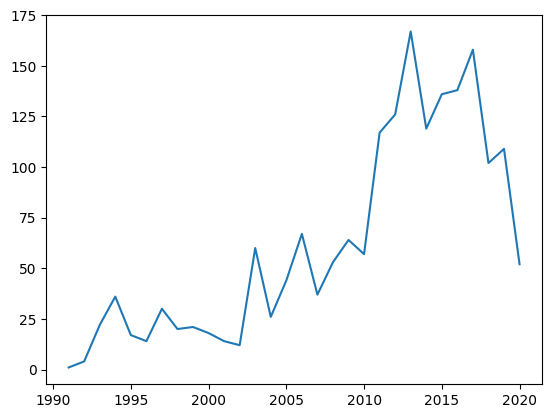

In [364]:
plt.plot(df['year'],df['Total'],  label = 'total amount of earthquakes')

In [547]:
df = store[['Total', 'year']]

scaler=MinMaxScaler(feature_range=(0,1))
df.index=df.year
df.drop('year',axis=1,inplace=True)
final_data = df.values


train_data=final_data[0:25,:]
valid_data=final_data[25:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)

x_train_data,y_train_data=[],[]
for i in range(20,len(train_data))
    x_train_data.append(scaled_data[i-20:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)



In [548]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data)[0],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

model_data=df[len(df)-len(valid_data)-25:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

In [549]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=3,verbose=2)
X_test=[]

for i in range(0,model_data.shape[0]):
    X_test.append(model_data[i-25:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

ValueError: in user code:

    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_56" is incompatible with the layer: expected shape=(None, 5, 1), found shape=(None, 20)


In [556]:
#lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=3,verbose=2)
#x_train_data.shape
#y_train_data 
#model_data.shape[0]
y_train_data.shape

(5,)

In [470]:
predicted_earthquakes=lstm_model.predict(X_test)
predicted_earthquakes=scaler.inverse_transform(predicted_earthquakes)

ValueError: in user code:

    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\alexd\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_29" is incompatible with the layer: expected shape=(None, 20, 1), found shape=(None, 0, 1)


In [554]:
df.values.shape

(30, 1)